In [80]:
import pickle
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('..')
from rectangles_drawing import calculate_one_pixels_diffs
from osm_object import Image_OSM_object

from circle_diagram import calculate_sectors_count, create_circle_diagram
from circle_diagram import Image_circle_diagrams

In [3]:
def read_pickle(filepath):
    with open(filepath, 'rb') as f:
        return pickle.load(f)
    
def dump_pickle(filepath, obj):
    with open(filepath, 'wb') as f:
        pickle.dump(obj, f)

## Предыдущие результаты замеров точности

In [4]:
points = read_pickle('../dataset/100_random_points.pickle')
points_to_centers_6_8 = read_pickle('../dataset/100_points_to_cell_centers_48cells_6x8.pickle')
points_to_centers_3_4 = read_pickle('../dataset/100_points_to_cell_centers_12cells_3x4.pickle')

In [5]:
ideal_means_6_8 = read_pickle('../dataset/ideal_means_48cells_6x8.pickle')
predicted_means_6_8 = read_pickle("../dataset/predicted_means_48cells_6x8.pickle")

ideal_means_3_4 = read_pickle('../dataset/ideal_means_12cells_3x4.pickle')
predicted_means_3_4 = read_pickle("../dataset/predicted_means_12cells_3x4.pickle")

Это уже итоговые результаты: одно значение - средняя вероятность попадания в нужный квадрат для одной картинки. Нужны немного другие значения, так что придётся пересчитать.

## Более подробные замеры точности

In [6]:
predictions_folder = '../dataset/predictions/'
predicts_osm_folder = 'predicts_osm'
orig_osm_objects_path = '../dataset/osm_objects/'

In [11]:
train_val_test = read_pickle("../dataset/train_val_test_split.pickle")
test_ids = train_val_test['test']

In [7]:
predicts_osm_objects_path = os.path.join(predictions_folder, predicts_osm_folder)

In [9]:
bigger_side_blocks_count = 8
sectors_count = calculate_sectors_count(bigger_side_blocks_count)
print("Sectors count:", sectors_count)

Sectors count: 616


### Все вероятности для одной точки

#### Построение круговых диаграмм для изображения

In [12]:
img_id = test_ids[0]
filename_pickle = img_id + '.pickle'

img_osm = read_pickle(os.path.join(predicts_osm_objects_path, filename_pickle))

In [13]:
img_osm.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=True)

#### Построение круговой диаграммы агента для одной точки (для оригинальных данных)

In [14]:
agent_point = points[0]

In [15]:
img_osm_for_agent = read_pickle(os.path.join(orig_osm_objects_path, filename_pickle))
img_osm_for_agent.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)

agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm_for_agent)
agent_cd.make_fast()

#### Подсчёт вероятностей попадания в каждый из квадратов для этой диаграммы агента

In [16]:
def calculate_cells_probs(img_cds, agent_cd):
    """
    only fast version
    """
    penalties = []
    
    for i in range(len(img_cds.center_points)):
        penalties.append(img_cds.fast_diagrams[i].dist_to(agent_cd.fast_diagram))
        
    # Добавл. 1e-8 чтобы не было нулей
    similaryties = np.max(penalties) - penalties + 1e-8

    return similaryties / similaryties.sum()

In [17]:
%%time
cell_probs = calculate_cells_probs(img_cds, agent_cd)

CPU times: user 290 ms, sys: 2.5 ms, total: 293 ms
Wall time: 298 ms


In [18]:
cell_probs

array([2.09353424e-02, 6.59438415e-13, 1.21996107e-03, 1.35551281e-02,
       2.09976175e-02, 2.24428881e-02, 2.26480469e-02, 2.26627015e-02,
       2.15911161e-02, 1.91896649e-02, 1.58759859e-02, 1.94699262e-02,
       2.17486464e-02, 2.22615425e-02, 2.25985890e-02, 2.26553742e-02,
       2.18603855e-02, 2.09536597e-02, 2.05909715e-02, 2.09866326e-02,
       2.19593012e-02, 2.22670385e-02, 2.24868520e-02, 2.26553742e-02,
       2.20252451e-02, 2.19593012e-02, 2.18274146e-02, 2.19757872e-02,
       2.20747030e-02, 2.24373941e-02, 2.24868520e-02, 2.26388883e-02,
       2.23055064e-02, 2.22725345e-02, 2.21076749e-02, 2.22560485e-02,
       2.23055064e-02, 2.24868520e-02, 2.24960106e-02, 2.26462156e-02,
       2.24703660e-02, 2.24373941e-02, 2.24209081e-02, 2.24373941e-02,
       2.24703660e-02, 2.25363098e-02, 2.26352256e-02, 2.26773562e-02])

#### Проверка того, что в одном из k секторов с максимальной уверенностью находится точка

In [112]:
img_cds.center_points

[(25.0, 25.0),
 (25.0, 75.0),
 (25.0, 125.0),
 (25.0, 175.0),
 (25.0, 225.0),
 (25.0, 275.0),
 (25.0, 325.0),
 (25.0, 375.0),
 (75.0, 25.0),
 (75.0, 75.0),
 (75.0, 125.0),
 (75.0, 175.0),
 (75.0, 225.0),
 (75.0, 275.0),
 (75.0, 325.0),
 (75.0, 375.0),
 (125.0, 25.0),
 (125.0, 75.0),
 (125.0, 125.0),
 (125.0, 175.0),
 (125.0, 225.0),
 (125.0, 275.0),
 (125.0, 325.0),
 (125.0, 375.0),
 (175.0, 25.0),
 (175.0, 75.0),
 (175.0, 125.0),
 (175.0, 175.0),
 (175.0, 225.0),
 (175.0, 275.0),
 (175.0, 325.0),
 (175.0, 375.0),
 (225.0, 25.0),
 (225.0, 75.0),
 (225.0, 125.0),
 (225.0, 175.0),
 (225.0, 225.0),
 (225.0, 275.0),
 (225.0, 325.0),
 (225.0, 375.0),
 (275.0, 25.0),
 (275.0, 75.0),
 (275.0, 125.0),
 (275.0, 175.0),
 (275.0, 225.0),
 (275.0, 275.0),
 (275.0, 325.0),
 (275.0, 375.0)]

In [113]:
agent_point

(316, 231)

In [115]:
points_to_centers_6_8[agent_point][::-1]

(225.0, 325.0)

In [19]:
def find_center_point_id(center_points, agent_point):
    for i in range(len(center_points)):
        if center_points[i] == agent_point:
            return i

In [21]:
center_point_id = find_center_point_id(img_cds.center_points, points_to_centers_6_8[agent_point][::-1])

In [29]:
print(center_point_id)

38


In [27]:
np.argsort(cell_probs * 100)[::-1]

array([47,  7, 15, 23,  6, 39, 31, 46, 14, 45, 38, 22, 37, 30, 44, 40,  5,
       29, 43, 41, 42, 32, 36, 33, 21, 13, 35, 34, 28, 24, 27, 20, 25, 16,
       26, 12,  8,  4, 19, 17,  0, 18, 11,  9, 10,  3,  2,  1])

In [30]:
cell_probs[np.argsort(cell_probs * 100)[::-1]]

array([2.26773562e-02, 2.26627015e-02, 2.26553742e-02, 2.26553742e-02,
       2.26480469e-02, 2.26462156e-02, 2.26388883e-02, 2.26352256e-02,
       2.25985890e-02, 2.25363098e-02, 2.24960106e-02, 2.24868520e-02,
       2.24868520e-02, 2.24868520e-02, 2.24703660e-02, 2.24703660e-02,
       2.24428881e-02, 2.24373941e-02, 2.24373941e-02, 2.24373941e-02,
       2.24209081e-02, 2.23055064e-02, 2.23055064e-02, 2.22725345e-02,
       2.22670385e-02, 2.22615425e-02, 2.22560485e-02, 2.21076749e-02,
       2.20747030e-02, 2.20252451e-02, 2.19757872e-02, 2.19593012e-02,
       2.19593012e-02, 2.18603855e-02, 2.18274146e-02, 2.17486464e-02,
       2.15911161e-02, 2.09976175e-02, 2.09866326e-02, 2.09536597e-02,
       2.09353424e-02, 2.05909715e-02, 1.94699262e-02, 1.91896649e-02,
       1.58759859e-02, 1.35551281e-02, 1.21996107e-03, 6.59438415e-13])

In [53]:
def is_in_one_of_max_k(cell_probs, center_point_id, max_k):
    is_ok_for_different_k = []
    
    argsort = np.argsort(cell_probs)[::-1]
    for k in range(0, max_k):
        if argsort[k] == center_point_id:
            is_ok_for_different_k += [True for _ in range(max_k - k)]
            break
        else:
            is_ok_for_different_k.append(False)
        
    return is_ok_for_different_k

In [54]:
%%time
is_in_one_of_max_k(cell_probs, center_point_id, 11)

CPU times: user 170 µs, sys: 1 µs, total: 171 µs
Wall time: 149 µs


[False, False, False, False, False, False, False, False, False, False, True]

#### Подсчёт этого же самого для всех точек на одном изображении

In [55]:
def is_in_ks_for_one_image(img_id, max_k=48):
    
    filename_pickle = img_id + '.pickle'
    img_osm = read_pickle(os.path.join(predicts_osm_objects_path, filename_pickle))
    img_osm.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
    img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=True)
    
    is_in_k_one_image = []
    
    for agent_point in points:
        img_osm_for_agent = read_pickle(os.path.join(orig_osm_objects_path, filename_pickle))
        img_osm_for_agent.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
        agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm_for_agent)
        agent_cd.make_fast()
        
        cell_probs = calculate_cells_probs(img_cds, agent_cd)
        
        center_point_id = find_center_point_id(img_cds.center_points, points_to_centers_6_8[agent_point][::-1])
        
        is_in_k_one_point = is_in_one_of_max_k(cell_probs, center_point_id, max_k)
        is_in_k_one_image.append(is_in_k_one_point)
        
    return is_in_k_one_image

In [56]:
%%time
is_in_k_one_image = is_in_ks_for_one_image(test_ids[0])

CPU times: user 28.9 s, sys: 67.3 ms, total: 29 s
Wall time: 29.2 s


In [67]:
# точность на одной картинке (да и на всех так же можно посчитать будет)
np.array(is_in_k_one_image)[:, 0].sum() / len(is_in_k_one_image)

0.01

#### Теперь для всех картинок

In [69]:
%%time
is_in_k = []

for img_id in test_ids[:100]:
    
    is_in_k += is_in_ks_for_one_image(img_id)
    
    if len(is_in_k) % 1000 == 0:
        print(len(is_in_k))
        

../utils.py:38: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(scalar_product / (norm_1 * norm_2)))


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
CPU times: user 42min 6s, sys: 5.79 s, total: 42min 12s
Wall time: 42min 29s


In [70]:
is_in_k = np.array(is_in_k)

In [71]:
np.save("../dataset/is_in_k_6_8.npy", is_in_k)

In [83]:
acc_in_k = []
for i in range(48):
    acc_in_k.append(is_in_k[:, i].sum() / is_in_k.shape[0])

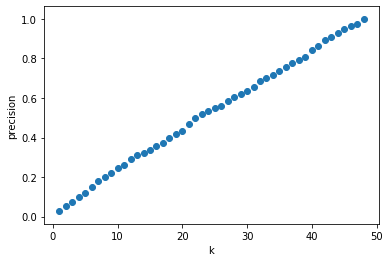

In [99]:
plt.scatter(np.array(list(range(48))) + 1, acc_in_k)
plt.xlabel('k')
plt.ylabel('precision')
plt.show()

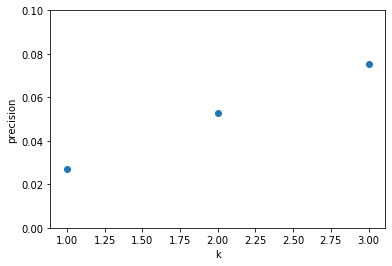

In [105]:
plt.scatter(np.array(list(range(3))) + 1, acc_in_k[:3])
plt.xlabel('k')
plt.ylabel('precision')
plt.ylim(0, 0.1)
plt.show()

In [110]:
for k in range(48):
    print(f"K: {k + 1} - {acc_in_k[k]}")

K: 1 - 0.027
K: 2 - 0.0528
K: 3 - 0.0754
K: 4 - 0.1013
K: 5 - 0.117
K: 6 - 0.1479
K: 7 - 0.1778
K: 8 - 0.2005
K: 9 - 0.2213
K: 10 - 0.2469
K: 11 - 0.2623
K: 12 - 0.2921
K: 13 - 0.3101
K: 14 - 0.3203
K: 15 - 0.3362
K: 16 - 0.3571
K: 17 - 0.371
K: 18 - 0.4
K: 19 - 0.4195
K: 20 - 0.4354
K: 21 - 0.466
K: 22 - 0.4969
K: 23 - 0.5179
K: 24 - 0.5349
K: 25 - 0.5498
K: 26 - 0.5614
K: 27 - 0.5833
K: 28 - 0.6026
K: 29 - 0.6194
K: 30 - 0.635
K: 31 - 0.6547
K: 32 - 0.6846
K: 33 - 0.6999
K: 34 - 0.7184
K: 35 - 0.7384
K: 36 - 0.7586
K: 37 - 0.7788
K: 38 - 0.7922
K: 39 - 0.8092
K: 40 - 0.8412
K: 41 - 0.8653
K: 42 - 0.8944
K: 43 - 0.909
K: 44 - 0.9284
K: 45 - 0.9482
K: 46 - 0.9628
K: 47 - 0.9769
K: 48 - 1.0


Похоже на случайные предсказания...

Можно померить, долю попаданий в нужный квадрат или один из квадратов вокруг. 

То есть что квадрат с максимальной вероятностью - один из этих.

Или что квадрат с k - 1 максимальной вероятностью один из этих, или что k - 2.

In [107]:
cell_probs

array([2.09353424e-02, 6.59438415e-13, 1.21996107e-03, 1.35551281e-02,
       2.09976175e-02, 2.24428881e-02, 2.26480469e-02, 2.26627015e-02,
       2.15911161e-02, 1.91896649e-02, 1.58759859e-02, 1.94699262e-02,
       2.17486464e-02, 2.22615425e-02, 2.25985890e-02, 2.26553742e-02,
       2.18603855e-02, 2.09536597e-02, 2.05909715e-02, 2.09866326e-02,
       2.19593012e-02, 2.22670385e-02, 2.24868520e-02, 2.26553742e-02,
       2.20252451e-02, 2.19593012e-02, 2.18274146e-02, 2.19757872e-02,
       2.20747030e-02, 2.24373941e-02, 2.24868520e-02, 2.26388883e-02,
       2.23055064e-02, 2.22725345e-02, 2.21076749e-02, 2.22560485e-02,
       2.23055064e-02, 2.24868520e-02, 2.24960106e-02, 2.26462156e-02,
       2.24703660e-02, 2.24373941e-02, 2.24209081e-02, 2.24373941e-02,
       2.24703660e-02, 2.25363098e-02, 2.26352256e-02, 2.26773562e-02])

In [108]:
argsort = np.argsort(cell_probs)[::-1]

In [109]:
center_point_id

38

In [154]:
# 8 точек вокруг
def find_points_ids_around(center_point_id, bigger_side_blocks_count, max_center_point_id):
    """
    max_center_point_id = 47, если сетка 6x8
    """
    
    points_ids_around = [center_point_id]
    # всегда нужно проверять, что не вышли за границы
    
    point_left = None
    point_right = None
    
    if center_point_id % bigger_side_blocks_count != 0:
        point_left = center_point_id - 1
        points_ids_around.append(point_left)
    
    if center_point_id % bigger_side_blocks_count != (bigger_side_blocks_count - 1):
        point_right = center_point_id + 1
        points_ids_around.append(point_right)
        
    point_up = center_point_id - bigger_side_blocks_count
    if point_up >= 0:
        points_ids_around.append(point_up)
    
    point_down = center_point_id + bigger_side_blocks_count
    if point_down <= max_center_point_id:
        points_ids_around.append(point_down)
        
    if point_left is not None and point_up > 0: 
        # слева сверху
        points_ids_around.append(point_up - 1)
        
    if point_right is not None and point_down < max_center_point_id:
        # справа снизу
        points_ids_around.append(point_down + 1)

    if point_left is not None and point_down <= max_center_point_id:
        # слева снизу
        points_ids_around.append(point_down - 1)
        
    if point_right is not None and point_up >= 0:
        # справа сверху
        points_ids_around.append(point_up + 1)
        
    return points_ids_around

In [164]:
find_points_ids_around(47, bigger_side_blocks_count=8, max_center_point_id=47)

[47, 46, 39, 38]

In [165]:
# Теперь для каждой точки из points найдём точки вокруг

In [168]:
points_around = []
for point in points:
    center_point_id = find_center_point_id(img_cds.center_points, points_to_centers_6_8[point][::-1])
    points_around.append(find_points_ids_around(center_point_id, bigger_side_blocks_count, max_center_point_id=47))

In [169]:
points_around = np.array(points_around)

In [170]:
points_around[0]

[38, 37, 39, 30, 46, 29, 47, 45, 31]

In [178]:
def is_in_one_of_max_k_around(cell_probs, p_around, max_k):
    is_ok_for_different_k = []
    
    argsort = np.argsort(cell_probs)[::-1]
    for k in range(0, max_k):
        if argsort[k] in p_around:
            is_ok_for_different_k += [True for _ in range(max_k - k)]
            break
        else:
            is_ok_for_different_k.append(False)
        
    return is_ok_for_different_k

In [179]:
is_in_one_of_max_k_around(cell_probs, points_around[0], max_k=48)

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [176]:
def is_in_points_around_in_ks_for_one_image(img_id, max_k=48):
    """
    Проверям, попали ли мы в одну из точек вокруг с наибольшей вероятностью?
    А с одной из двух наибольших вероятностей?
    А с одной из трёх?
    И так для всех до max_k
    """
    
    filename_pickle = img_id + '.pickle'
    img_osm = read_pickle(os.path.join(predicts_osm_objects_path, filename_pickle))
    img_osm.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
    img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=True)
    
    is_in_k_one_image = []
    
    for i in range(len(points)):
        agent_point = points[i]
        p_around = points_around[i]

        img_osm_for_agent = read_pickle(os.path.join(orig_osm_objects_path, filename_pickle))
        img_osm_for_agent.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
        agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm_for_agent)
        agent_cd.make_fast()
        
        cell_probs = calculate_cells_probs(img_cds, agent_cd)
        
        center_point_id = find_center_point_id(img_cds.center_points, points_to_centers_6_8[agent_point][::-1])
        
        is_in_k_one_point = is_in_one_of_max_k_around(cell_probs, p_around, max_k)
        is_in_k_one_image.append(is_in_k_one_point)
        
    return is_in_k_one_image

In [180]:
%%time
res = is_in_points_around_in_ks_for_one_image(test_ids[0])

CPU times: user 26.5 s, sys: 12 ms, total: 26.5 s
Wall time: 26.5 s


In [189]:
one_img_res = []

for i in range(47):
    one_img_res.append(np.array(res)[:, i].sum() / len(res))

(0, 1.044)

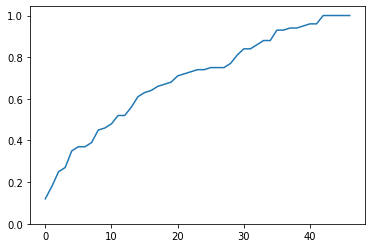

In [192]:
plt.plot(list(range(47)), one_img_res)
plt.ylim(0)

In [193]:
%%time
# А теперь для всех картинок!

is_in_k_around = []

for img_id in test_ids[:100]:
    
    is_in_k_around += is_in_points_around_in_ks_for_one_image(img_id, max_k=48)
    
    if len(is_in_k_around) % 1000 == 0:
        print(len(is_in_k_around))
        

../utils.py:38: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(scalar_product / (norm_1 * norm_2)))


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
CPU times: user 39min, sys: 1.02 s, total: 39min 1s
Wall time: 39min 1s


In [195]:
is_in_k_around = np.array(is_in_k_around)

In [196]:
np.save("../dataset/is_in_k_6_8_around.npy", is_in_k_around)

In [197]:
acc_in_k_around = []
for i in range(48):
    acc_in_k_around.append(is_in_k_around[:, i].sum() / is_in_k_around.shape[0])

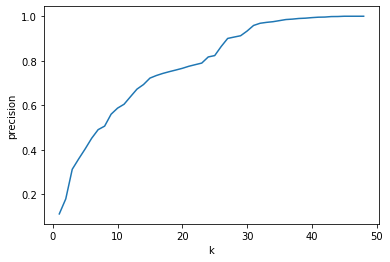

In [198]:
plt.plot(np.array(list(range(48))) + 1, acc_in_k_around)
plt.xlabel('k')
plt.ylabel('precision')
plt.show()

In [199]:
for k in range(48):
    print(f"K: {k + 1} - {acc_in_k_around[k]}")

K: 1 - 0.1119
K: 2 - 0.1794
K: 3 - 0.3124
K: 4 - 0.3593
K: 5 - 0.4042
K: 6 - 0.4518
K: 7 - 0.4905
K: 8 - 0.5063
K: 9 - 0.5599
K: 10 - 0.5872
K: 11 - 0.6046
K: 12 - 0.6389
K: 13 - 0.6727
K: 14 - 0.6931
K: 15 - 0.7221
K: 16 - 0.7338
K: 17 - 0.7432
K: 18 - 0.7511
K: 19 - 0.7584
K: 20 - 0.766
K: 21 - 0.7752
K: 22 - 0.7825
K: 23 - 0.7896
K: 24 - 0.8171
K: 25 - 0.8233
K: 26 - 0.8641
K: 27 - 0.9003
K: 28 - 0.9065
K: 29 - 0.9124
K: 30 - 0.9335
K: 31 - 0.9586
K: 32 - 0.9684
K: 33 - 0.9725
K: 34 - 0.9755
K: 35 - 0.9803
K: 36 - 0.9852
K: 37 - 0.9871
K: 38 - 0.99
K: 39 - 0.9913
K: 40 - 0.9938
K: 41 - 0.9957
K: 42 - 0.9963
K: 43 - 0.9985
K: 44 - 0.9988
K: 45 - 1.0
K: 46 - 1.0
K: 47 - 1.0
K: 48 - 1.0


In [200]:
1 / 48

0.020833333333333332

In [201]:
9 / 48

0.1875

Получаем по сути случайность

Для приличия посчитаем ещё и для 3x4, но там, скорее всего будет то же самое.

Есть идея выделить картинки, на которых должно работать лучше чем рандом.

Случаи, когда нельзя сделать лучше, чем рандом:

- на картинке только 1 объект
- на картинке нет объектов

P.S. valley и ridge не используются, так что их выкидываем - считаем, что объектов нет

Ещё один случай, в котором, скорее всего, ничего не будет работать - на картинке остаются объекты только одного типа и их очень много